In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
from helpers import lift_dataset
# lift_dataset devuelve un iterador
dataset = list(lift_dataset('../dataset/2012-07-15.original-annotation.release'))
len(dataset)

33635

In [4]:
df = pd.DataFrame(dataset)
df.columns = ['event_1', 'event_2', 'relationship', 'text', 'source_file']
df[:6]

,event_1,event_2,relationship,text,source_file
0,"EVENT=""Admission"" 1:0 1:0","TIMEX3=""2014-03-31"" 2:0 2:0","type=""SIMULTANEOUS""\n",Admission Date : 2014-03-31,193.xml.tlink
1,"EVENT=""Discharge"" 3:0 3:0","TIMEX3=""2014-04-09"" 4:0 4:0","type=""SIMULTANEOUS""\n",Discharge Date : 2014-04-09,193.xml.tlink
2,"EVENT=""admitted"" 9:4 9:4","EVENT=""Nantucket Cottage Hospital"" 9:11 9:13","type=""OVERLAP""\n",The patient has been admitted 5 x in the past ...,193.xml.tlink
3,"TIMEX3=""2014-04-04"" 48:1 48:1","EVENT=""labs"" 48:3 48:3","type=""SIMULTANEOUS""\n","On 2014-04-04 , labs were as follows :",193.xml.tlink
4,"EVENT=""WBC"" 49:0 49:0","TIMEX3=""2014-04-04"" 48:1 48:1","type=""SIMULTANEOUS""\n","On 2014-04-04 , labs were as follows : WBC of ...",193.xml.tlink
5,"EVENT=""hematocrit"" 49:4 49:4","TIMEX3=""2014-04-04"" 48:1 48:1","type=""SIMULTANEOUS""\n","On 2014-04-04 , labs were as follows : WBC of ...",193.xml.tlink


## Mostramos la cantidad de muestras por cada tipo de relacion entre eventos.

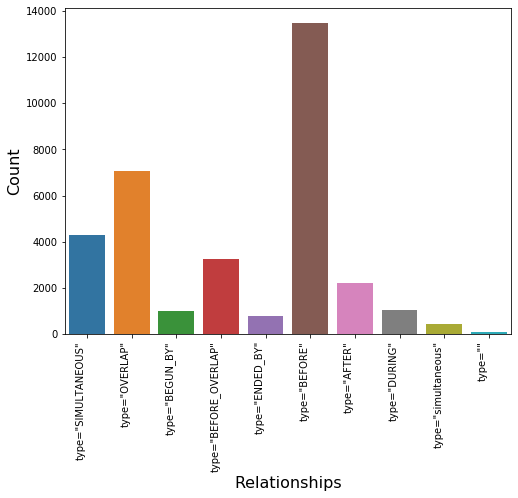

In [5]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x="relationship", data=df)
ax.set_xlabel(xlabel='Relationships', fontsize=16)
ax.set_ylabel(ylabel='Count', fontsize=16)
plt.xticks(rotation='vertical')
plt.show();

En el grafico de arriba podemos ver un desbalanceo en los datos. Tambien hay un tipo de relacion sin nombre.

## Mostramos las 20 tokens mas frecuentes.

In [6]:
import spacy
import spacy.attrs
from collections import Counter
spacy_nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])
df['text_as_doc'] = df['text'].apply(lambda x: spacy_nlp(x))
df['text_tokens'] = df['text_as_doc'].apply(lambda doc: [token.text for token in doc if token.is_punct == False])
words = []
for tokens in df['text_tokens']:
  words.extend(tokens)
word_freq = Counter(words)
common_words = [x[0] for x in word_freq.most_common(20)]
common_words_count = [x[1] for x in word_freq.most_common(20)]

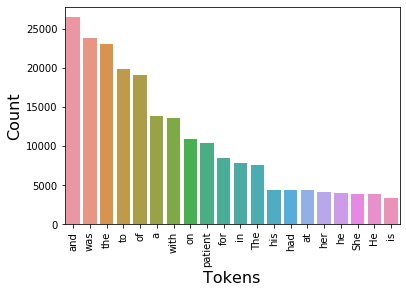

In [7]:
ax = sns.barplot(x=common_words, y=common_words_count)
ax.set_xlabel(xlabel='Tokens', fontsize=16)
ax.set_ylabel(ylabel='Count', fontsize=16)
plt.xticks(rotation='vertical')
plt.show();

En el grafico de arriba podemos ver que como es esperado las "stop words" son las mas frecuentes.

## Metricas sobre la cantidad de tokens de cada ejemplo

In [8]:
df['text_tokens_len'] = df['text_tokens'].apply(lambda x: len(x))
df['text_tokens_len'].describe()

count    33635.000000
mean        22.887885
std         11.972122
min          1.000000
25%         14.000000
50%         21.000000
75%         29.000000
max        123.000000
Name: text_tokens_len, dtype: float64

Estas metricas las podremos usar para luego saber que ventana utilizar en embeddings po ejemplo.

## t-SNE

In [9]:
import numpy as np
from sklearn.manifold import TSNE
import plotly
import pickle
from gensim.models.keyedvectors import KeyedVectors
plotly.offline.init_notebook_mode(connected=True)

# load embeddings
embeddings = KeyedVectors.load_word2vec_format('../dataset/PubMed-shuffle-win-2.bin', binary=True)

In [96]:
def get_coordinates(model, sentences, perplexities):
    s_arr = np.empty((0,200), dtype='f')
    for s in sentences:
        w_arr = np.empty((0,200), dtype='f')
        for w in s:
            try:
                wrd_vector = model[w]
            except:
                wrd_vector = np.random.normal(size=(200,)) 
#                 wrd_vector = np.zeros(200)
            w_arr = np.append(w_arr, np.array([wrd_vector]), axis=0)
        s_mean = np.mean(w_arr, axis=0)
        s_arr = np.append(s_arr, [s_mean], axis=0)
        
    coords = {}
    for perplexity in perplexities:
        tsne = TSNE(n_components=3, random_state=0, early_exaggeration=1, perplexity=perplexity)
        np.set_printoptions(suppress=True)
        Y = tsne.fit_transform(s_arr)
        x_coords = Y[:, 0]
        y_coords = Y[:, 1]
        z_coords = Y[:, 2]
        coords[perplexity] = x_coords, y_coords, z_coords
        
    return coords

In [50]:
text_1 = df.iloc[df.groupby(['relationship']).groups['type="BEFORE"\n']]['text'].tolist()
text_2 = df.iloc[df.groupby(['relationship']).groups['type="OVERLAP"\n']]['text'].tolist()

In [51]:
import spacy
def tokenize_sentences(sentences):
    spacy_nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])
    sentences_tokens = []
    for x in sentences:
        tokens = []
        doc = spacy_nlp(x)
        for token in doc:
            tokens.append(token.text)
        sentences_tokens.append(tokens)
    return sentences_tokens

text_1_as_tokens = tokenize_sentences(text_1)
text_2_as_tokens = tokenize_sentences(text_2)

In [52]:
print(len(text_1_as_tokens))
print(len(text_2_as_tokens))

13467
7061


In [113]:
# acotamos para tener una primera impresion.
import random
random.seed(47)
text_1_as_tokens_samples = random.choices(text_1_as_tokens, k=100)
text_2_as_tokens_samples = random.choices(text_2_as_tokens, k=100)

In [114]:
print(len(text_1_as_tokens_samples))
print(len(text_2_as_tokens_samples))

100
100


In [120]:
coords = get_coordinates(embeddings, text_1_as_tokens_samples + text_2_as_tokens_samples, perplexities=[10, 30, 40])
medl = len(text_1_as_tokens_samples)

In [121]:
for k, v in coords.items():
    x, y, z = v
    plot1 = plotly.graph_objs.Scatter3d(x=x[:medl],
                         y=y[:medl],
                         z=z[:medl],
                         mode='markers+text',
                         name='BEFORE',
                         marker=dict(
                             color='rgb(12, 12, 12)',
                             size=12,
                             symbol='circle',
                             line=dict(color='rgba(217, 217, 217, 0.14)',
                                       width=1),
                             opacity=0.9
            ))
    plot2 = plotly.graph_objs.Scatter3d(x=x[medl:],
                         y=y[medl:],
                         z=z[medl:],
                         mode='markers+text',
                         name='OVERLAP',
                         marker=dict(
                             color='rgb(180, 180, 180)',
                             size=12,
                             symbol='circle',
                             line=dict(color='rgba(217, 217, 217, 0.14)',
                                       width=1),
                             opacity=0.9
            ))
    layout = plotly.graph_objs.Layout(title='Perplexity {}'.format(k))
    fig = plotly.graph_objs.Figure(data=[plot1, plot2], layout=layout)
    plotly.offline.iplot(fig)